Shape: (148670, 34)
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           

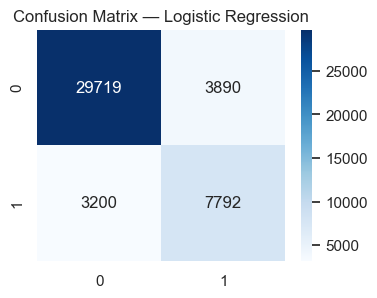


Training Model: Naive Bayes
Train Accuracy: 0.7363
Test Accuracy: 0.869
Training Time: 0.318536 sec
Prediction Time: 0.073032 sec


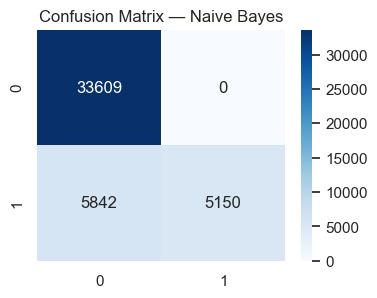


Training Model: SVM
Train Accuracy: 0.5738
Test Accuracy: 0.4552
Training Time: 52.096937 sec
Prediction Time: 0.692377 sec


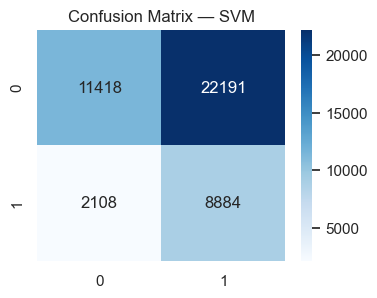


Training Model: Decision Tree
Train Accuracy: 1.0
Test Accuracy: 0.9999
Training Time: 1.006119 sec
Prediction Time: 0.01566 sec


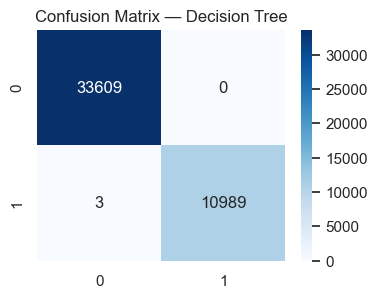


Training Model: Random Forest
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 30.38326 sec
Prediction Time: 1.033071 sec


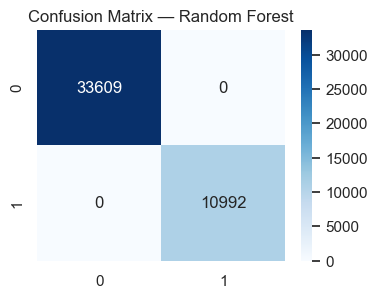


Training Model: XGBoost
Train Accuracy: 1.0
Test Accuracy: 1.0
Training Time: 1.21899 sec
Prediction Time: 0.020936 sec


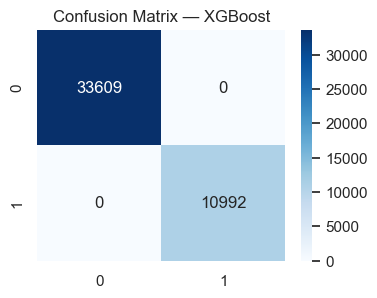


Training Model: KNN
Train Accuracy: 0.9189
Test Accuracy: 0.7966
Training Time: 0.16356 sec
Prediction Time: 30.239173 sec


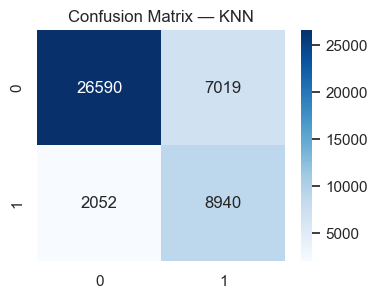


===== FINAL RESULTS =====

                 Model  Train Accuracy  Train Sensitivity  Train Specificity  \
0  Logistic Regression       79.959068          71.783428          88.134707   
1          Naive Bayes       73.626023          47.252047         100.000000   
2                  SVM       57.384407          81.058887          33.709928   
3        Decision Tree      100.000000         100.000000         100.000000   
4        Random Forest      100.000000         100.000000         100.000000   
5              XGBoost      100.000000         100.000000         100.000000   
6                  KNN       91.891944          98.385657          85.398230   

     Train F1   Train AUC  Test Accuracy  Test Sensitivity  Test Specificity  \
0   78.174711   87.374149      84.103495         70.887918         88.425719   
1   64.178458   99.999983      86.901639         46.852256        100.000000   
2   65.542129   65.486246      45.519159         80.822416         33.973043   
3  100.0000

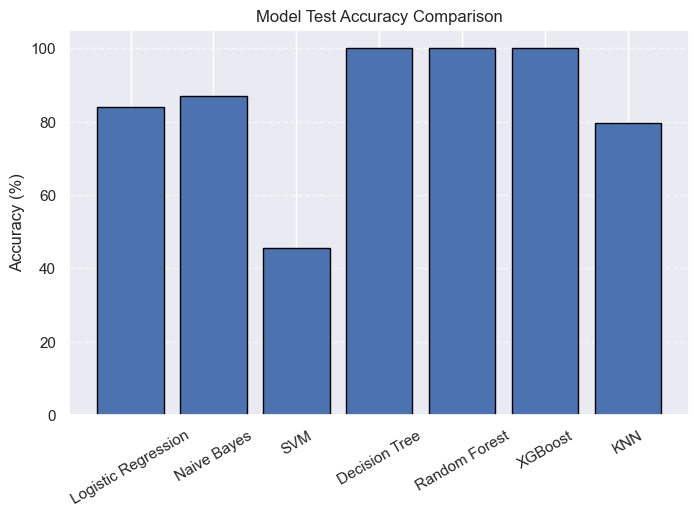

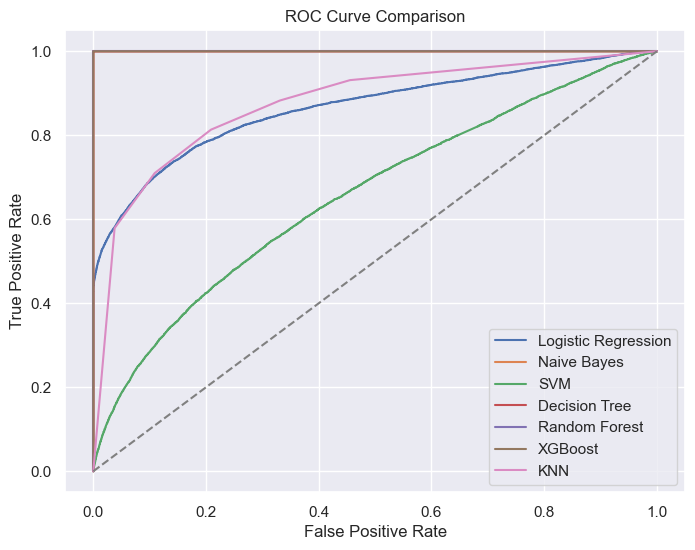

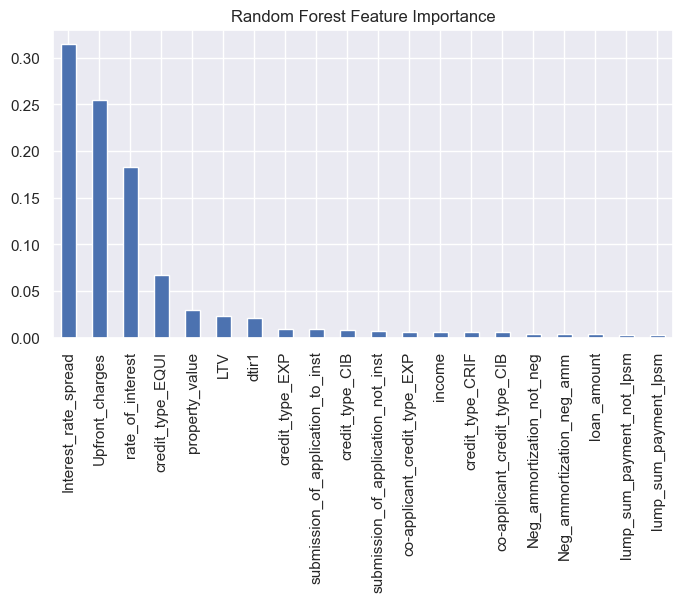

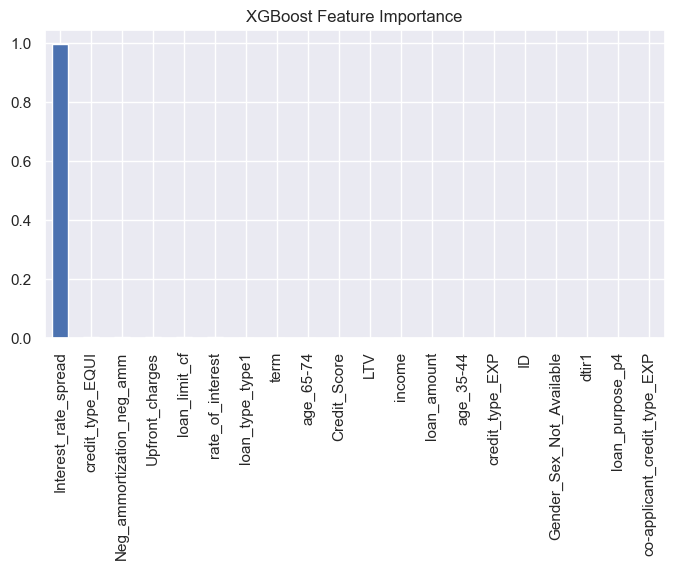

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb


from imblearn.over_sampling import SMOTE
import joblib   



# LOAD DATASET

df = pd.read_csv("data/Loan_default.csv")
print("Shape:", df.shape)
print(df.head())

TARGET = "Status"

print("\nTarget distribution before cleaning:")
print(df[TARGET].value_counts())



# HANDLE MISSING VALUES

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

if TARGET in cat_cols:
    cat_cols.remove(TARGET)

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after cleaning:")
print(df.isnull().sum())



# Label encode target
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

# Select categorical features 
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET in cat_cols:
    cat_cols.remove(TARGET)

# Only perform encoding if there are categorical columns
if len(cat_cols) > 0:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    encoded_cat = pd.DataFrame(
        encoder.fit_transform(df[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=df.index
    )

    
    df = df.drop(columns=cat_cols)

    
    df = pd.concat([df, encoded_cat], axis=1)

   
    joblib.dump(encoder, "encoder.pkl")
    print("OneHotEncoder saved to encoder.pkl")

print("Shape after OneHotEncoding (if any):", df.shape)


X = df.drop(columns=[TARGET])
y = df[TARGET]

X.columns = (
    X.columns
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace('<', '', regex=False)
    .str.replace('>', '', regex=False)
    .str.replace('/', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nTrain/Test Split Done:")
print("Train:", X_train.shape, "| Test:", X_test.shape)


scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

numeric_cols = X_train.select_dtypes(include=[np.number]).columns

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])



sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

print("\nBefore SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_sm.value_counts().to_dict())



models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', max_iter=500, probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


results = []
trained_models = {}


for name, model in models.items():
    print("\n===============================")
    print(f"Training Model: {name}")
    print("===============================")



    start_train = time.time()
    model.fit(X_train_sm, y_train_sm)
    end_train = time.time()
    train_time = end_train - start_train

    trained_models[name] = model

    y_train_pred = model.predict(X_train_sm)
    train_accuracy = accuracy_score(y_train_sm, y_train_pred)

    tn, fp, fn, tp = confusion_matrix(y_train_sm, y_train_pred).ravel()
    train_sensitivity = tp / (tp + fn)
    train_specificity = tn / (tn + fp)
    train_f1 = f1_score(y_train_sm, y_train_pred)

    try:
        train_auc = roc_auc_score(y_train_sm, model.predict_proba(X_train_sm)[:,1])
    except:
        train_auc = None

    start_pred = time.time()
    y_pred = model.predict(X_test_scaled)
    end_pred = time.time()
    infer_time = end_pred - start_pred

    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = None

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_specificity = tn / (tn + fp)

    results.append([
        name,
        train_accuracy * 100,
        train_sensitivity * 100,
        train_specificity * 100,
        train_f1 * 100,
        train_auc * 100 if train_auc else None,
        acc * 100,
        rec * 100,
        test_specificity * 100,
        f1 * 100,
        auc * 100 if auc else None,
        train_time,
        infer_time
    ])

    print("Train Accuracy:", round(train_accuracy, 4))
    print("Test Accuracy:", round(acc, 4))
    print("Training Time:", round(train_time, 6), "sec")
    print("Prediction Time:", round(infer_time, 6), "sec")

     # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.show()



results_df = pd.DataFrame(results, columns=[
    "Model",
    "Train Accuracy", "Train Sensitivity", "Train Specificity",
    "Train F1", "Train AUC",
    "Test Accuracy", "Test Sensitivity", "Test Specificity",
    "Test F1", "Test AUC",
    "Training Time (sec)", "Prediction Time (sec)"
])

print("\n===== FINAL RESULTS =====\n")
print(results_df)




joblib.dump(trained_models, "models.pkl")


joblib.dump(scaler, "scaler.pkl")



joblib.dump(X_train_scaled.columns.tolist(), "columns.pkl")

joblib.dump(list(numeric_cols), "numeric_cols.pkl")

print("\n===== Saved Files =====")
print("✔ models.pkl (all trained models)")
print("✔ scaler.pkl")
print("✔ encoder.pkl (already saved earlier)")
print("✔ columns.pkl")
print("✔ numeric_cols.pkl")


plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["Test Accuracy"], edgecolor="black")
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(8, 6))
for name, model in trained_models.items():
    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)
    except:
        continue

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


def plot_importances(model, title):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=X.columns)
        imp.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,4))
        plt.title(title)
        plt.show()

plot_importances(trained_models["Random Forest"], "Random Forest Feature Importance")
plot_importances(trained_models["XGBoost"], "XGBoost Feature Importance")
